In [1]:
# Import required modules
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
from LeXmo import LeXmo
import pickle
import os
from tqdm.notebook import tqdm
import statsmodels.formula.api as sm
from scipy.stats import t 
import matplotlib.pyplot as plt
import sys

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
sp = "sp500" # sp500 or sp600

In [3]:
df_path = "data/earning_call_dataframe/df_final_"+sp    ##############CHANGE
# df_path = "data/df_final"
with open(df_path,"rb") as file :
    df_final = pickle.load(file)

In [4]:
display(df_final)

,id,date,ticker,text,earning_call_quarter
0,4264085,2019-05-14,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q1
1,4285738,2019-08-14,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q2
2,4309111,2019-11-26,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q3
3,4325101,2020-02-18,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q4
4,4349475,2020-05-21,A,Question-and-Answer Session\n \nOperator\n \n[...,2020Q1
...,...,...,...,...,...
1855,4422752,2021-04-30,DRE,Question-and-Answer Session\n \nOperator\n \n[...,2021Q1
1856,4442846,2021-07-29,DRE,Question-and-Answer Session\n \nOperator\n \nT...,2021Q2
1857,4463265,2021-10-28,DRE,Question-and-Answer Session\n \nOperator\n \nT...,2021Q3
1858,4482287,2022-01-27,DRE,Question-and-Answer Session \n \nOperator\n \n...,2021Q4


# Import datas from yahoo finance

In [5]:
# Get the month from which we import stock returns :
    # Q1 : from january (1) to march (3)
    # Q2 : from april (4) to june (6)
    # Q3 : from july (7) to septmber (9)
    # Q4 : from october (10) to december (12)

#df_final['earning_call_quarter'] = pd.to_datetime(df_final['earning_call_quarter'])
df_final['date'] = pd.to_datetime(df_final['date'])

# Quarters start 1 end
quarter_start = df_final['earning_call_quarter'].iloc[0].quarter
quarter_end = df_final['earning_call_quarter'].iloc[-1].quarter 

# Months start 1 end
month_start = quarter_start*2-1
month_end = quarter_end*3

# Day end : 30 or 31 ?
if month_end in [3,12]:
    day_end = 31
else:
    day_end = 30


In [6]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

# Take a margin of 1 year to calculate abnormal returns
start = datetime.datetime(df_final['earning_call_quarter'].iloc[0].year-1,month_start,2)
end   = datetime.datetime(df_final['earning_call_quarter'].iloc[-1].year+1,month_end,day_end)

# Create empty dataframe
stock_final = pd.DataFrame()

# Iterate over each symbol
list_tickers = list(set(list(df_final['ticker'])))
for i in list_tickers:  
    
    # print the symbol which is being downloaded
    print( str(list_tickers.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['ticker']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        
display(stock_final)

0 : CZR,1 : ABMD,2 : BBY,3 : DFS,4 : AEE,5 : DD,6 : DGX,7 : CDAY,8 : CF,9 : BRO,10 : ADP,11 : CI,12 : C,13 : BSX,14 : ADSK,15 : ADM,16 : AOS,17 : CMG,18 : CAT,19 : BIIB,20 : A,21 : ANET,22 : ABBV,23 : BDX,24 : COF,25 : CAH,26 : AMAT,27 : ALK,28 : AMP,29 : BEN,30 : BBWI,31 : CHRW,32 : APA,33 : AME,34 : ABT,35 : AAL,36 : CINF,37 : BR,38 : DAL,39 : DLR,40 : AON,41 : DHR,42 : AMZN,43 : CB,44 : AVY,45 : APH,46 : ATO,47 : BA,48 : CBOE,49 : CDW,50 : ARE,51 : ALL,52 : CHTR,53 : BMY,54 : CBRE,55 : DHI,56 : D,57 : BXP,58 : CDNS,59 : BALL,60 : APTV,61 : AAPL,62 : CCI,63 : ALGN,64 : AES,65 : CME,66 : AVB,67 : BLK,68 : BK,69 : BKR,70 : ALB,71 : ANTM,72 : AIG,73 : CPT,74 : DLTR,75 : AZO,76 : AFL,77 : CMI,78 : AXP,79 : APD,80 : ANSS,81 : BKNG,82 : CE,83 : DRE,84 : AEP,85 : CSX,86 : CTSH,87 : CMA,88 : CLX,89 : DG,90 : DIS,91 : AKAM,92 : CMS,93 : BAC,94 : AIZ,95 : CHD,96 : CVS,97 : DOV,98 : DE,99 : CL,

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2018-01-02,33.299999,33.299999,31.200001,31.650000,31.650000,1157300,CZR
2018-01-03,31.650000,32.000000,31.250000,31.299999,31.299999,715000,CZR
2018-01-04,31.600000,32.125000,31.400000,32.000000,32.000000,706500,CZR
2018-01-05,32.200001,32.549999,31.450001,31.799999,31.799999,538300,CZR
2018-01-08,31.799999,33.098999,31.250000,31.700001,31.700001,373200,CZR
...,...,...,...,...,...,...,...
2022-06-10,76.180000,77.250000,75.150002,76.629997,76.629997,4294600,CL
2022-06-13,75.430000,76.830002,75.430000,76.190002,76.190002,4490600,CL
2022-06-14,75.860001,76.040001,73.660004,74.269997,74.269997,3960400,CL


In [7]:
# Saves datas
df_path = "data/stock_final"+sp
with open(df_path,"wb") as file : 
    pickle.dump(stock_final, file, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open(df_path,"rb") as file :
    stock_final = pickle.load(file)

# Drop useless columns
stock_final = stock_final.drop(columns = ['Open','High','Low','Close','Volume'])
stock_final = stock_final.reset_index()
stock_final = stock_final.groupby(['ticker','Date']).last()

# Calculate stock returns
stock_final['stock_return'] = stock_final['Adj Close'].pct_change()

# Remove first date of each stock
stock_final = stock_final.drop(stock_final.groupby('ticker',as_index=False).nth(0).index)
stock_final = stock_final.reset_index()
stock_final = stock_final.drop(columns = ['Adj Close'])
display(stock_final)

,ticker,Date,stock_return
0,A,2018-01-03,0.025444
1,A,2018-01-04,-0.007501
2,A,2018-01-05,0.015988
3,A,2018-01-08,0.002146
4,A,2018-01-09,0.024554
...,...,...,...
112116,DRE,2022-06-10,-0.038625
112117,DRE,2022-06-13,0.009843
112118,DRE,2022-06-14,0.018500
112119,DRE,2022-06-15,0.048437


In [9]:
# Market datas

# Market ticker
if sp == "sp500":
    sp_ticker = 'SPY' 
elif sp == "sp600":
    sp_ticker = '^SP600' 

# Import market datas
mkt =  yf.download(sp_ticker, start=start, end=end, progress=False)
# Compute market return
mkt['market_return'] = mkt['Adj Close'].pct_change()
mkt = mkt.drop(columns = ['Adj Close','Open','High','Low','Close','Volume'])
# Drop first row
mkt = mkt[1:]

# Abnormal returns

In [10]:
# Parameter
number_days_end = 30
number_days_start = 30

# Initialisation of final dataframe
df_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

# Vector of normalized_date
normalized_date = np.concatenate((np.arange(-number_days_start , 0, 1, dtype=int),[0], np.arange(0, number_days_end +1, 1, dtype=int)))

# Get list of different tickers of the dataframe
list_tickers = list(set(list(df_final['ticker'])))

In [11]:
for symbol in tqdm(list_tickers):

    # Calculate abnormal returns of each stock
    df_stock = stock_final[stock_final['ticker'] == symbol]
    df_stock = df_stock.set_index('Date')
    df_stock = pd.merge(df_stock, mkt, left_index=True, right_index=True)
    df_stock['abnormal_return'] = df_stock['stock_return']-df_stock['market_return']
    df_stock = df_stock.drop(columns = ['stock_return', 'market_return'])
    ######################################## first change. Id value for row of return are max int
    df_stock['id'] = sys.maxsize*len(df_stock)
    #df_stock['id'] = 0*len(df_stock)
    first_column = df_stock.pop('id')
    df_stock.insert(0, 'id', first_column)

    # Dataframe with publication date of earning transcript
    df_final_stock = df_final[df_final['ticker'] == symbol]
    df_final_stock= df_final_stock.set_index('date')
    df_final_stock = df_final_stock.drop(columns = ['earning_call_quarter','text'])
    df_final_stock['abnormal_return']=0*len(df_final_stock)

    # Concatenate 2 previous dataframe and sort by date
    result = pd.concat([df_stock,df_final_stock])
    result = result.reset_index()
    result = result.rename(columns={'index': 'date'})
    result = result.sort_values(by=['date', 'id'])
    ################################### Because of first change if trading day
    # [return i-1, publication row date i , return i , return i+1] and for non trading day publication
    # [return i-1, return i, publication row date (i+1-i)/2, return i+1 , return i+2 ]
    # where return i = (Price i - Price i-1)/Price i -1
    # so for both case the first return of the position that we take from the strategy is 2 element to the
    # right from the publication row. For publication in trading day date i it is return i+1 as position is taken at Price i 
    # so return is return i+1 = (Price i+1 -Price i )/Price i
    # for publication in non trading day date (i+1-i)/2 it is return i+1 as position is take at Price i+1 
    # so return is return i+1 = (Price i+2- Price i+1)/Price i+1
    result = result.reset_index()

    # Get the indices of parution dates
    indices = result.loc[result['abnormal_return'] == 0].index.values
    indices = indices[:-1] # remove most recent earning call

    for i in indices: # loop for each earning call 
        first_df=[]
        ########################### Second change so that we take the right return now
        # The first left element in respect to publication row date is the relative abnormal return -1
        first_df = result[i-(number_days_start) :i+(number_days_end+2)]
        first_df['normalized_date']=normalized_date
        first_df=first_df[first_df.index != i]
        first_df['cum_ab_return']=first_df['abnormal_return'].cumsum(axis = 0)
        column_title= result['id'].loc[i]
        df_plot[column_title]=first_df['cum_ab_return'].values

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_7451/2167183313.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_df['normalized_date']=normalized_date
/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_7451/2167183313.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plot[column_title]=first_df['cum_ab_return'].values


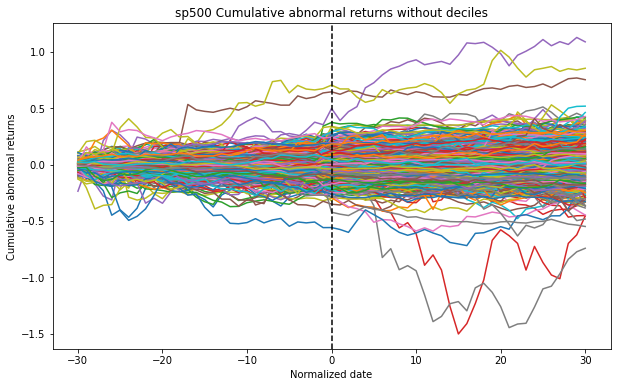

In [12]:
col = list(df_plot)
col.remove('normalized_date')
title = sp+" Cumulative abnormal returns without deciles"
plot = df_plot.plot(x='normalized_date',y=col,figsize=(10,6))
plot.get_legend().remove()
plt.axvline(x=0,color="black",linestyle="--")
plt.xlabel("Normalized date")
plt.ylabel("Cumulative abnormal returns")
plt.title(title)
plt.savefig('./data/abnormal_graphs/'+title, bbox_inches='tight')

In [13]:
#score_method = 'FiGAS' #figas or finbert
#content = 'text'  # 'text' or 'corpus'
#score = 'sent_score' # 'sent_score' or 'sent_score_rough'

In [14]:
def plot_with_deciles(col,score_method,content,score):
    file = "data/sentiment_score/"+score_method+"/"+score_method+ "_" + sp +"_by_"+content +"_final.csv"  #### CHANGE
    merged = []

    # Create score dataframe
    sentiment_text = pd.read_csv(file)  
    if score_method =='FiGAS':
        sentiment_text = sentiment_text.drop(columns = ['Unnamed: 0'])
    if score_method =='FinBert':
        sentiment_text = sentiment_text.rename(columns={"ID": "id"})
    sentiment_text['id'] = sentiment_text['id'].map(str)

    # Get the ids of dataframe col
    col_id = pd.DataFrame(col, columns =['id'])

    # Merge
    merged = pd.merge(col_id, sentiment_text, on='id')
    merged = merged.sort_values(by=[score])

    # Create deciles
    # merged['decile'] = 1 + merged[score].transform(lambda y:pd.qcut(y,10,labels=False,duplicates='drop'))
    merged['decile'] = 1+ pd.qcut(merged[score], 10, labels=False,duplicates='drop')

    # Compute abnormal returns for each decile
    df_decile_plot = []
    df_decile_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

    for i in range(1,11):
        dec1 = merged.loc[merged['decile'].isin([i])]
        long1 = dec1.id
        long1 = long1.to_list()

        df_mean = df_plot[long1].mean(axis=1)
        df_decile_plot['decile'+str(i)]=df_mean

    # Plot
    col = list(df_decile_plot)
    col.remove('normalized_date')
    title = sp+" Cumulative abnormal returns based on " +score_method+ " score (using "+ content + " and "+ score+")"
    plot = df_decile_plot.plot(x='normalized_date',y=col,figsize=(10,6))
    plt.axvline(x=0,color="black",linestyle="--")
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.xlabel("Normalized date")
    plt.ylabel("Cumulative abnormal returns")
    if sp == "sp600" : 
        y_limit = [-0.04, 0.065];
    elif sp == "sp500" :
        y_limit = [-0.04, 0.04];
    plt.ylim(y_limit)
    plt.title(title)
    plt.savefig('./data/abnormal_graphs/'+title, bbox_inches='tight')

# Figas

## sent_score

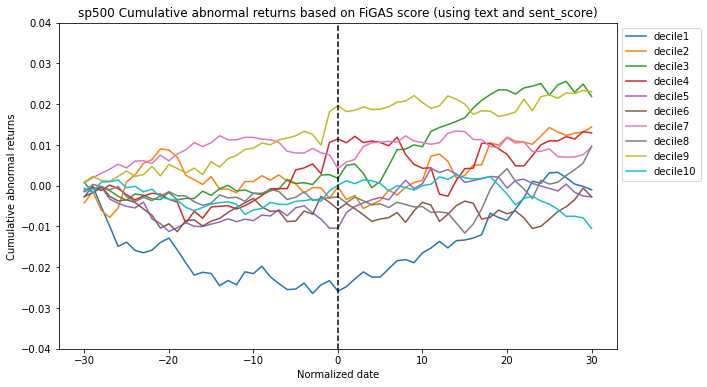

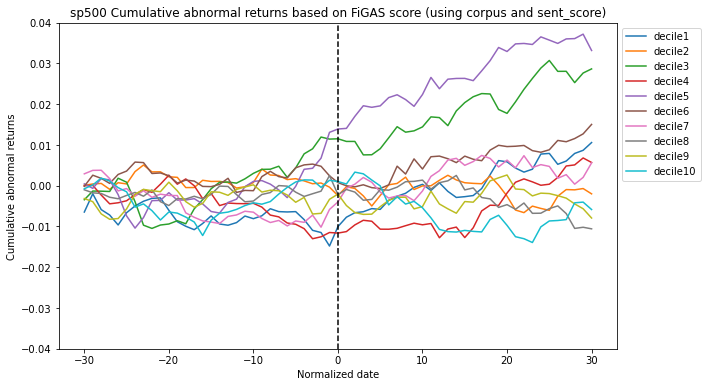

In [15]:
plot_with_deciles(col,'FiGAS','text','sent_score')
plot_with_deciles(col,'FiGAS','corpus','sent_score')

## sent_score_rough

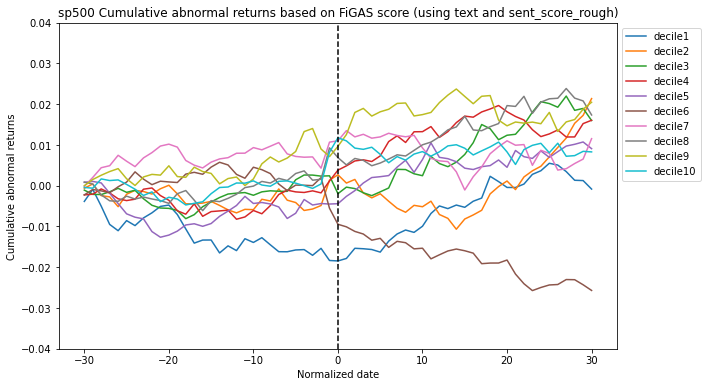

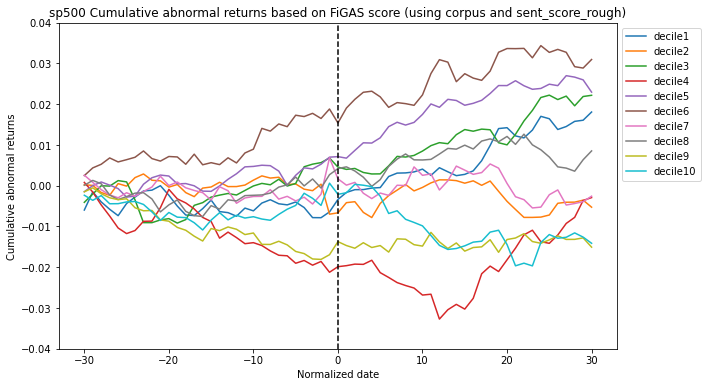

In [16]:
plot_with_deciles(col,'FiGAS','text','sent_score_rough')
plot_with_deciles(col,'FiGAS','corpus','sent_score_rough')

# FinBert

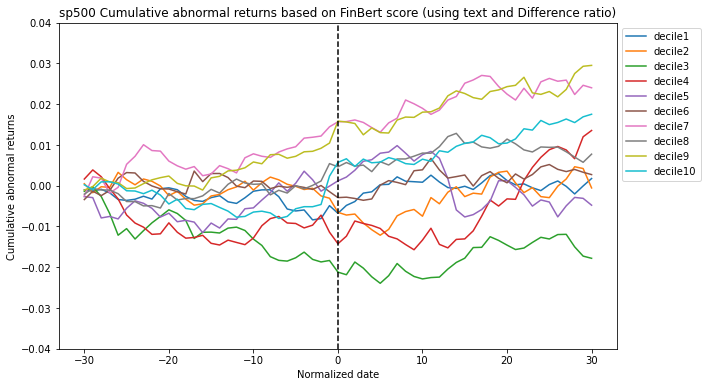

In [17]:
plot_with_deciles(col,'FinBert','text','Difference ratio')